# rmsc03 log exploration
Set `run_id` to the directory under `log/` for your `rmsc03` run. This notebook mirrors the earlier ones (summary log, fundamentals, agent logs) and adds a helper cell to generate the liquidity telemetry plot using `util/plotting/liquidity_telemetry.py`.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
run_id = 'rmsc03_log'  # TODO: replace with actual directory name
log_dir = Path('..') / 'log' / run_id
sorted(log_dir.iterdir())[:10]

[PosixPath('../log/rmsc03_log/ADAPTIVE_POV_MARKET_MAKER_AGENT_5101.bz2'),
 PosixPath('../log/rmsc03_log/ADAPTIVE_POV_MARKET_MAKER_AGENT_5102.bz2'),
 PosixPath('../log/rmsc03_log/EXCHANGE_AGENT.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5103.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5104.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5105.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5106.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5107.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5108.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5109.bz2')]

## Summary log

In [38]:
summary = pd.read_pickle(log_dir / 'summary_log.bz2')
wide_summary = (summary
                .pivot_table(index=['AgentID', 'AgentStrategy'],
                             columns='EventType', values='Event', aggfunc='first'))
wide_summary['PNL'] = wide_summary['ENDING_CASH'] - wide_summary['STARTING_CASH']
wide_summary.reset_index().head(20)

EventType,AgentID,AgentStrategy,ENDING_CASH,FINAL_CASH_POSITION,FINAL_VALUATION,STARTING_CASH,PNL
0,1,NoiseAgent,10017100.0,18970300.0,0.887082,10000000.0,17100.0
1,2,NoiseAgent,10000000.0,12895969.0,0.289597,10000000.0,0.0
2,3,NoiseAgent,10002976.0,3605920.0,-0.629413,10000000.0,2976.0
3,4,NoiseAgent,10002400.0,14595316.0,0.459532,10000000.0,2400.0
4,5,NoiseAgent,9998300.0,7503475.0,-0.249652,10000000.0,-1700.0
5,6,NoiseAgent,10000504.0,10000504.0,0.000050,10000000.0,504.0
6,7,NoiseAgent,10000000.0,13594996.0,0.359500,10000000.0,0.0
7,8,NoiseAgent,10008536.0,14385304.0,0.438530,10000000.0,8536.0
8,9,NoiseAgent,10000378.0,4607128.0,-0.529300,10000000.0,378.0
9,10,NoiseAgent,10000000.0,13095691.0,0.309569,10000000.0,0.0


### Aggregate P&L by strategy

In [39]:
wide_summary.groupby(level=1)['PNL'].describe()

,count,mean,std,min,25%,50%,75%,max
AgentStrategy,,,,,,,,
AdaptivePOVMarketMakerAgent,2.0,-280602.0000,354629.607114,-531363.0,-405982.5,-280602.0,-155221.5,-29841.0
ExecutionAgent,1.0,0.0000,NaN,0.0,0.0,0.0,0.0,0.0
MomentumAgent,25.0,57892.1600,26842.788652,10713.0,38112.0,57792.0,83244.0,99342.0
NoiseAgent,5000.0,46.5058,4637.355465,-27508.0,-420.0,0.0,429.0,30672.0
ValueAgent,100.0,-739.6600,152075.341386,-338528.0,-102640.0,5878.5,117385.5,332714.0


## Fundamental path

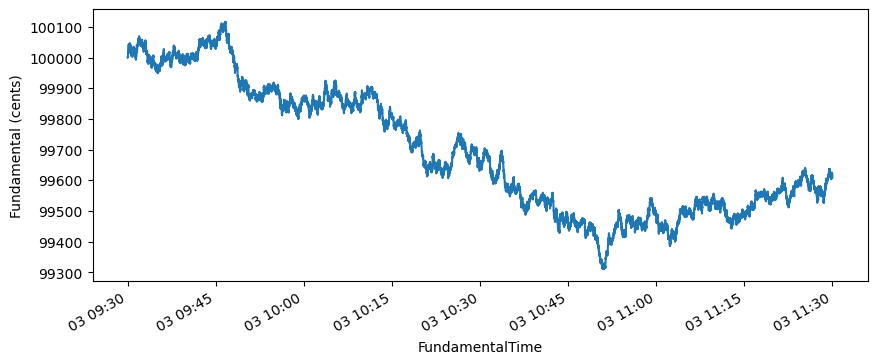

In [40]:
# Derive ticker from ORDERBOOK filename (e.g., ORDERBOOK_JPM_FULL.bz2)
orderbook_file = next(log_dir.glob('ORDERBOOK_*_FULL.bz2'))
ticker = orderbook_file.name.split('_')[1]

fundamental_path = log_dir / f'fundamental_{ticker}.bz2'
fundamental = pd.read_pickle(fundamental_path).reset_index()

fundamental.plot(x='FundamentalTime', y='FundamentalValue', legend=False, figsize=(10, 4))
plt.ylabel('Fundamental (cents)')
plt.show()


## Agent logs

In [41]:
def load_agent_log(filename):
    return pd.read_pickle(log_dir / filename)
agent_files = [f for f in sorted(log_dir.iterdir()) if f.suffix == '.bz2' and 'summary' not in f.name]
agent_files[:10]

[PosixPath('../log/rmsc03_log/ADAPTIVE_POV_MARKET_MAKER_AGENT_5101.bz2'),
 PosixPath('../log/rmsc03_log/ADAPTIVE_POV_MARKET_MAKER_AGENT_5102.bz2'),
 PosixPath('../log/rmsc03_log/EXCHANGE_AGENT.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5103.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5104.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5105.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5106.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5107.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5108.bz2'),
 PosixPath('../log/rmsc03_log/MOMENTUM_AGENT_5109.bz2')]

In [42]:
adaptive_mm = load_agent_log('ADAPTIVE_POV_MARKET_MAKER_AGENT_5101.bz2')
adaptive_mm.head(20)

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,AdaptivePOVMarketMakerAgent
NaT,STARTING_CASH,10000000
2020-06-03 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2020-06-03 09:30:10.001341692,BID_DEPTH,"[(99949, 45)]"
2020-06-03 09:30:10.001341692,ASK_DEPTH,"[(99950, 5)]"
2020-06-03 09:30:10.001341692,IMBALANCE,"[45, 5]"
2020-06-03 09:30:10.001341742,ORDER_SUBMITTED,"{'agent_id': 5101, 'time_placed': '2020-06-03T09:30:10.001341742', 'symbol': 'ABM', 'quantity': 50000, 'is_buy_order': True, 'order_id': 5029, 'fill_price': None, 'tag': None, 'limit_price': 99349}"
2020-06-03 09:30:10.001341742,ORDER_SUBMITTED,"{'agent_id': 5101, 'time_placed': '2020-06-03T09:30:10.001341742', 'symbol': 'ABM', 'quantity': 50000, 'is_buy_order': False, 'order_id': 5030, 'fill_price': None, 'tag': None, 'limit_price': 100550}"
2020-06-03 09:30:10.001341742,ORDER_SUBMITTED,"{'agent_id': 5101, 'time_placed': '2020-06-03T09:30:10.001341742', 'symbol': 'ABM', 'quantity': 4160, 'is_buy_order': True, 'order_id': 5031, 'fill_price': None, 'tag': None, 'limit_price': 99415}"


In [43]:
value_agent = load_agent_log('ValueAgent5086.bz2')
value_agent.head(20)

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,ValueAgent
NaT,STARTING_CASH,10000000
2020-06-03 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2020-06-03 09:30:00.023308045,BID_DEPTH,"[(99836, 39)]"
2020-06-03 09:30:00.023308045,ASK_DEPTH,"[(99861, 146)]"
2020-06-03 09:30:00.023308045,IMBALANCE,"[39, 146]"
2020-06-03 09:30:00.023308045,ORDER_SUBMITTED,"{'agent_id': 5086, 'time_placed': '2020-06-03T09:30:00.023308045', 'symbol': 'ABM', 'quantity': 41, 'is_buy_order': True, 'order_id': 4463, 'fill_price': None, 'tag': None, 'limit_price': 99838}"
2020-06-03 09:30:00.046616049,ORDER_ACCEPTED,"{'agent_id': 5086, 'time_placed': '2020-06-03T09:30:00.023308045', 'symbol': 'ABM', 'quantity': 41, 'is_buy_order': True, 'order_id': 4463, 'fill_price': None, 'tag': None, 'limit_price': 99838}"
2020-06-03 09:30:06.412600510,CANCEL_SUBMITTED,"{'agent_id': 5086, 'time_placed': '2020-06-03T09:30:00.023308045', 'symbol': 'ABM', 'quantity': 41, 'is_buy_order': True, 'order_id': 4463, 'fill_price': None, 'tag': None, 'limit_price': 99838}"


In [44]:
momentum_agent = load_agent_log('MOMENTUM_AGENT_5105.bz2')
momentum_agent.head(20)

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,MomentumAgent
NaT,STARTING_CASH,10000000
2020-06-03 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2020-06-03 09:30:20.000549090,BID_DEPTH,"[(99955, 400)]"
2020-06-03 09:30:20.000549090,ASK_DEPTH,"[(99956, 7301)]"
2020-06-03 09:30:20.000549090,IMBALANCE,"[400, 7301]"
2020-06-03 09:30:40.001098180,BID_DEPTH,"[(100006, 19)]"
2020-06-03 09:30:40.001098180,ASK_DEPTH,"[(100009, 43)]"
2020-06-03 09:30:40.001098180,IMBALANCE,"[19, 43]"


In [45]:
noise_agent = load_agent_log('NoiseAgent4575.bz2')
noise_agent.head(20)

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,NoiseAgent
NaT,STARTING_CASH,10000000
2020-06-03 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2020-06-03 09:30:00.000465645,BID_DEPTH,[]
2020-06-03 09:30:00.000465645,ASK_DEPTH,"[(99793, 659)]"
2020-06-03 09:30:00.000465645,IMBALANCE,"[0, 659]"
2020-06-03 09:30:00.000465645,FINAL_HOLDINGS,{ CASH: 10000000 }
2020-06-03 09:30:00.000465645,FINAL_CASH_POSITION,10000000
2020-06-03 09:30:00.000465645,MARKED_TO_MARKET,10000000


In [46]:
exec_agent = load_agent_log('POV_EXECUTION_AGENT.bz2')
exec_agent.head(20)

,EventType,Event
EventTime,,
NaT,AGENT_TYPE,ExecutionAgent
NaT,STARTING_CASH,10000000
2020-06-03 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2020-06-03 11:31:00.000000050,FINAL_HOLDINGS,{ CASH: 10000000 }
2020-06-03 11:31:00.000000050,FINAL_CASH_POSITION,10000000
2020-06-03 11:31:00.000000050,MARKED_TO_MARKET,10000000
2020-06-03 11:31:00.000000050,ENDING_CASH,10000000


## Liquidity telemetry

In [49]:
# cd util
# cd plotting
# python liquidity_telemetry.py ../../log/rmsc03_log/EXCHANGE_AGENT.bz2 ../../log/rmsc03_log/ORDERBOOK_ABM_FULL.bz2  -o ../../log/rmsc03_log/liquidity_telemetry.png -c configs/plot_09.30_11.30.json   